In [1]:
from matplotlib import pyplot as plt
import numpy as np

from src.image_process.image_io import LoadImage

import src.image_process.pre_process as prep

import src.image_process.mask.mask_getters as maget

from src.image_process.edp_center.center_optimization.opt_funcs import Area
from src.image_process.edp_center.centroid import get_centroid
from src.image_process.edp_center.center_optimization.optimization import optimize_center

from src.image_process.diffraction_pattern import eDiffractionPattern
from src.image_process.polar.polar_representation import PolarRepresentation
from src.image_process.polar.rotational_average import RotationalAverage

In [159]:
file_path = 'data/20cm Ouro final.dm3'
load_image = LoadImage(file_path=file_path)

data = load_image.data

In [172]:
mean_mask = maget.MeanTreshMask(.1)
mask = maget.superpose_masks(data, [mean_mask])

In [173]:
penalty_func = Area(data, mask).get_penalty_func()
centroid = get_centroid(data)
center = optimize_center(penalty_func, data.shape, initial_guess=centroid)
center

(2024.9999993875365, 2114.9999436836247)

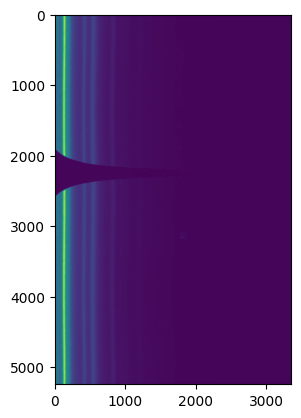

In [174]:
edp = eDiffractionPattern(data, center, mask)
polar_representation = PolarRepresentation(edp=edp)

polar_representation.radial_range = (0.06, .7)

plt.imshow(polar_representation.polar_image)

In [175]:
from src.image_process.ellipse.elp_params import EllipseParams

ellipse_params = EllipseParams(edp=edp)


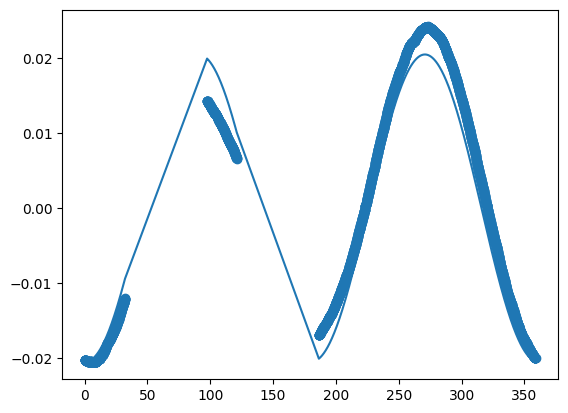

{'axis_ratio': 1.0207458711087507, 'orientation': 0.8124516425196617}

In [176]:
params = ellipse_params.measure_ellipse_params()
params

# Elliptical Correction

In [165]:
orientation, sc_fac = params['orientation'], (params['axis_ratio'] + 1) / 2
orientation, sc_fac

(0.8124516425196617, 1.0103729355543754)

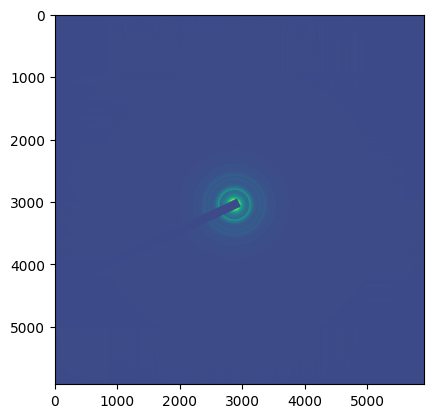

In [166]:
from src.image_process.utils import ImagePadder

img_padder = ImagePadder(data, center)

data8 = img_padder.square_padded_data.copy()

plt.imshow(data8)

In [167]:
l = round((np.linalg.norm(data8.shape) - np.max(data.shape)) / 2)

data_for_rot = np.pad(data8.copy(), l, mode='constant', constant_values=0)

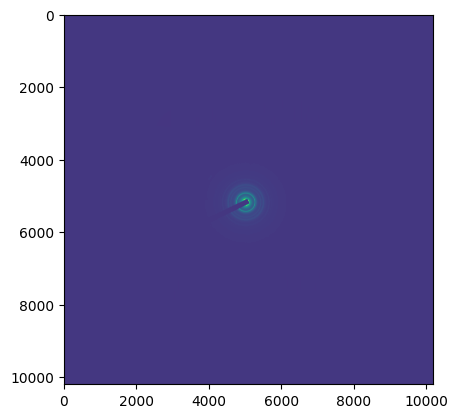

In [168]:
import cv2

M_semi = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), orientation, 1.0)
semi_rotated = cv2.warpAffine(data_for_rot.copy(), M_semi, data_for_rot.shape)

plt.imshow(semi_rotated)

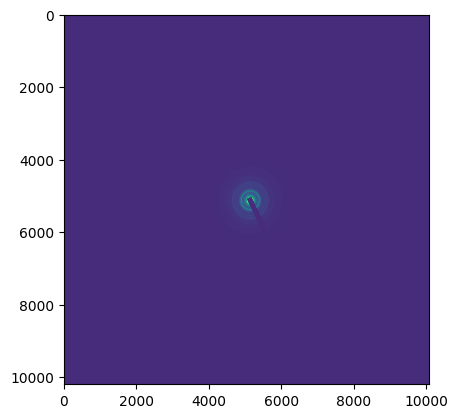

In [169]:
semi_corrected = cv2.resize(semi_rotated, (round(semi_rotated.shape[0]*sc_fac), semi_rotated.shape[1]), interpolation=cv2.INTER_CUBIC)

M = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), 90, 1.0)
rotated = cv2.warpAffine(semi_corrected, M, data_for_rot.shape)

corrected = cv2.resize(rotated, (round(rotated.shape[0]/sc_fac), rotated.shape[1]), interpolation=cv2.INTER_CUBIC)

plt.imshow(corrected)

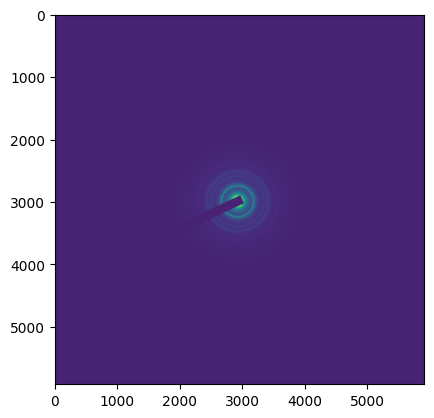

In [170]:
M_final = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), -(orientation+90), 1.0)
final_al = cv2.warpAffine(corrected.copy(), M_final, data_for_rot.shape)

final = final_al[l:l+data8.shape[0], l:l+data8.shape[0]]

plt.imshow(final)

In [171]:
data_final = img_padder.recover_original_shape(final).copy()

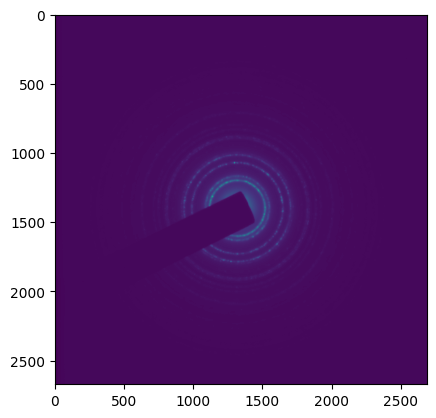

In [152]:
plt.imshow(data_final)

In [153]:
data = data_final.copy()